In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers, layers, models
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('train.csv') 
df2 = pd.read_csv('test.csv') 

X = df['text'].astype(str).values
y = df['label'].map({'non-sexist': 0, 'sexist': 1}).values.astype('int32')

X2 = df2['text'].astype(str).values
y_test = df2['label'].map({'non-sexist': 0, 'sexist': 1}).values.astype('int32')

In [3]:
MAX_LEN = 100
VOCAB_SIZE = 30000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X)  # Fit only on training data

# Tokenize and pad sequences
sequences_train = tokenizer.texts_to_sequences(X)
padded_sequences_train = pad_sequences(sequences_train, maxlen=MAX_LEN, padding='post')

sequences_test = tokenizer.texts_to_sequences(X2)
X_test = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post')

# Split training set for validation
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences_train, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

In [4]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X2)}")

Training set size: 4673
Validation set size: 1169
Test set size: 2279


In [5]:
glove_dim = 200 
fasttext_dim = 300

glove_path = 'glove.twitter.27B.200d.txt'
fasttext_path = 'crawl-300d-2M-subword.vec'

word_index = tokenizer.word_index


In [6]:
def load_embedding(file_path, word_index, embedding_dim, vocab_size):
    embeddings = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split()
            if len(values) < embedding_dim + 1:
                continue  # skip malformed lines
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load embeddings with vocab limit
glove_matrix = load_embedding(glove_path, word_index, glove_dim, VOCAB_SIZE)
fasttext_matrix = load_embedding(fasttext_path, word_index, fasttext_dim, VOCAB_SIZE)

In [228]:
inputs = Input(shape=(MAX_LEN,))

embedding_glove = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=glove_dim,
                            embeddings_initializer=Constant(glove_matrix),
                            trainable=False)(inputs)

embedding_fasttext = Embedding(input_dim=VOCAB_SIZE,
                               output_dim=fasttext_dim,
                               embeddings_initializer=Constant(fasttext_matrix),
                               trainable=True)(inputs)

embedding = Concatenate()([embedding_glove, embedding_fasttext])
embedding = SpatialDropout1D(0.4)(embedding)

# CNN Layer
cnn = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedding)
cnn = LayerNormalization()(cnn)

# Attention Mechanism
attention = Dense(1, activation='tanh')(cnn)  # Apply attention to CNN output
attention = Flatten()(attention)
attention = Activation('softmax')(attention)  # Softmax to assign attention weights
attention = RepeatVector(64)(attention)  # Repeat to match sequence length
attention = Permute([2, 1])(attention)  # Align with CNN output shape
attended = Multiply()([cnn, attention])  # Apply attention to the CNN output

# Pooling Layer
avg_pool = GlobalAveragePooling1D()(attended)
max_pool = GlobalMaxPooling1D()(attended)
x = Concatenate()([avg_pool, max_pool])

# Dense Layer
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(1, activation='sigmoid')(x)

# Model Definition
model = Model(inputs, outputs)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_70 (Embedding)       (None, 100, 200)     6000000     ['input_36[0][0]']               
                                                                                                  
 embedding_71 (Embedding)       (None, 100, 300)     9000000     ['input_36[0][0]']               
                                                                                                  
 concatenate_69 (Concatenate)   (None, 100, 500)     0           ['embedding_70[0][0]',           
                                                                  'embedding_71[0][0]']    

In [229]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

In [230]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
147/147 [==============================] - 4s 19ms/step - loss: 1.6525 - accuracy: 0.5018 - val_loss: 1.4921 - val_accuracy: 0.5133 - lr: 5.0000e-05
Epoch 2/50
147/147 [==============================] - 3s 17ms/step - loss: 1.3673 - accuracy: 0.5102 - val_loss: 1.2521 - val_accuracy: 0.5252 - lr: 5.0000e-05
Epoch 3/50
147/147 [==============================] - 3s 17ms/step - loss: 1.1630 - accuracy: 0.5106 - val_loss: 1.0809 - val_accuracy: 0.5672 - lr: 5.0000e-05
Epoch 4/50
147/147 [==============================] - 3s 18ms/step - loss: 1.0184 - accuracy: 0.5129 - val_loss: 0.9603 - val_accuracy: 0.5851 - lr: 5.0000e-05
Epoch 5/50
147/147 [==============================] - 3s 18ms/step - loss: 0.9167 - accuracy: 0.5262 - val_loss: 0.8764 - val_accuracy: 0.6176 - lr: 5.0000e-05
Epoch 6/50
147/147 [==============================] - 3s 18ms/step - loss: 0.8472 - accuracy: 0.5320 - val_loss: 0.8194 - val_accuracy: 0.6578 - lr: 5.0000e-05
Epoch 7/50
147/147 [====================

In [231]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

72/72 [==============================] - 0s 4ms/step - loss: 0.4157 - accuracy: 0.8583
Test Loss: 0.4157, Test Accuracy: 0.8583


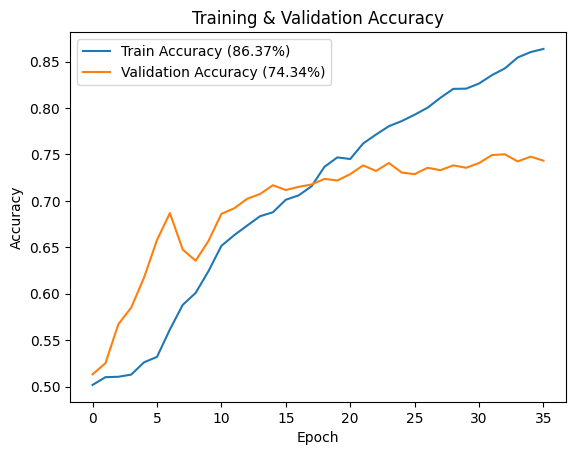

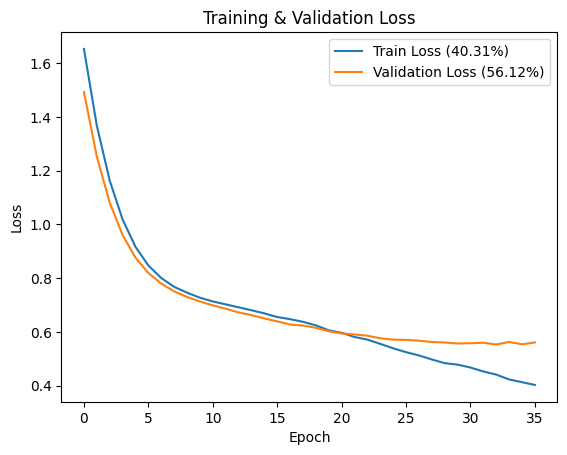

In [232]:
import matplotlib.pyplot as plt

# Extract final accuracy values
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

train_loss = history.history['loss'][-1] * 100
val_loss = history.history['val_loss'][-1] * 100


# Plot Accuracy with final percentage in labels
plt.plot(history.history['accuracy'], label=f'Train Accuracy ({train_acc:.2f}%)')
plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({val_acc:.2f}%)')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label=f'Train Loss ({train_loss:.2f}%)')
plt.plot(history.history['val_loss'], label=f'Validation Loss ({val_loss:.2f}%)')
plt.legend()
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

72/72 [==============================] - 0s 3ms/step
Accuracy: 0.8582711715664765
Precision: 0.8433544303797469
Recall: 0.8950461796809404
F1 Score: 0.8684317718940937

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1088
           1       0.84      0.90      0.87      1191

    accuracy                           0.86      2279
   macro avg       0.86      0.86      0.86      2279
weighted avg       0.86      0.86      0.86      2279



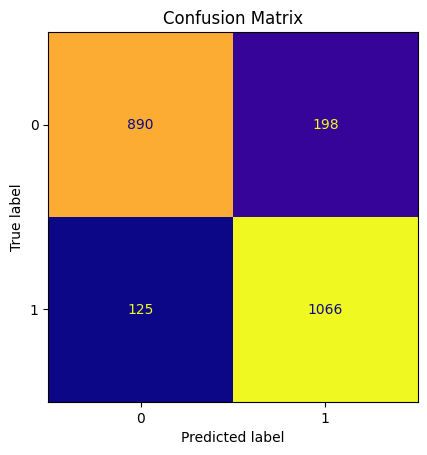

72/72 [==============================] - 0s 3ms/step


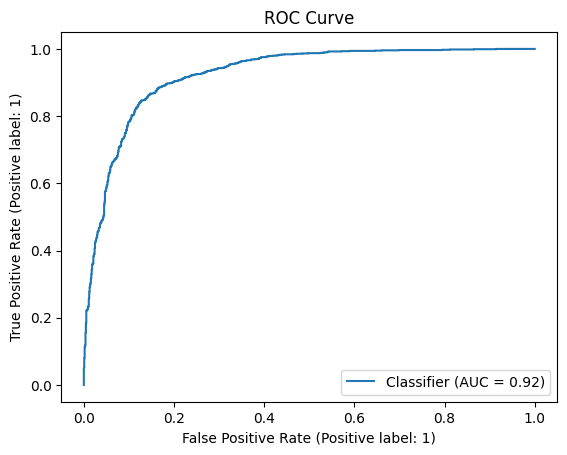

72/72 [==============================] - 0s 2ms/step
ROC-AUC Score: 0.9241461698029337


In [233]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Predictions
preds = (model.predict(X_test) > 0.5).astype(int)  # Use X_test here

# Metrics
print("Accuracy:", accuracy_score(y_test, preds))  # Use y_test
print("Precision:", precision_score(y_test, preds))  # Use y_test
print("Recall:", recall_score(y_test, preds))  # Use y_test
print("F1 Score:", f1_score(y_test, preds))  # Use y_test
print("\nClassification Report:\n", classification_report(y_test, preds))  # Use y_test

# Confusion Matrix
cm = confusion_matrix(y_test, preds)  # Use y_test
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, model.predict(X_test))  # Use X_test and y_test
plt.title("ROC Curve")
plt.show()

# AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict(X_test)))  # Use y_test

In [234]:
model.save('baseline-model2.h5')

In [235]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# Get probabilities and predictions
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype(int).reshape(-1)
y_probs = y_probs.reshape(-1)
y_test = np.array(y_test).reshape(-1)

reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(idx, '[UNK]') for idx in sequence if idx != 0])

# Convert all validation sequences back to text
X_val_texts = [sequence_to_text(seq) for seq in X_test]

# Create DataFrame
results_df = pd.DataFrame({
    'text': X_val_texts,               # list of original texts
    'true_label': y_test,
    'predicted_label': y_preds,
    'probability': y_probs
})

# False Positives: predicted sexist (1), actually non-sexist (0)
false_positives = results_df[(results_df['predicted_label'] == 1) & (results_df['true_label'] == 0)]
false_positives[['text', 'probability']].to_csv("false_positives_texts.csv", index=False)

# False Negatives: predicted non-sexist (0), actually sexist (1)
false_negatives = results_df[(results_df['predicted_label'] == 0) & (results_df['true_label'] == 1)]
false_negatives[['text', 'probability']].to_csv("false_negatives_texts.csv", index=False)

72/72 [==============================] - 0s 3ms/step


In [16]:
# Display False Positives
print("\n--- False Positives (predicted sexist, actually non-sexist) ---")
for i, row in false_positives.iterrows():
    print(f"[P: {row['probability']:.2f}] {row['text']}")

# Display False Negatives
print("\n--- False Negatives (predicted non-sexist, actually sexist) ---")
for i, row in false_negatives.iterrows():
    print(f"[P: {row['probability']:.2f}] {row['text']}")



--- False Positives (predicted sexist, actually non-sexist) ---
[P: 0.77] does anyone remember the evil mother hating skank who disowned her own mother for being a trump supporter well guess what she still hates trump and she is still dribbling anti american diatribe like a typical liberal
[P: 0.64] monkey see monkey do ass bitches
[P: 0.76] if i get more fans my boyfriend will join me you will get videos photos of my pussy mouth filled with cum my tits ass face covered with cum and shots of him fucking my face pussy
[P: 0.72] what leads to feminism abuse shame domestic violence et cetera should be stopped and everyone should collectively stop it by hand by one s words or if not by disliking it men and women should both actively speak against it and speak against human injustice
[P: 0.63] oo oo ohh we are in a relationship look at us we are so happy and together and you are so sad and alone how is it feel huh do you like it huh you like it right tell us you like it bitch fucking tell 

In [236]:
results_df.to_csv("baseline_predictions.csv", index=False)
print("Saved predictions to model_predictions.csv")

Saved predictions to model_predictions.csv
